In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
from pyspark.sql.functions import pandas_udf, PandasUDFType

from dprecs.taobao.data import get_candidates
from dprecs.auctions import run_auction_group, run_paper_auction
from dprecs.analysis import get_aggregates_pyspark
from dprecs.plotting import plot_aggregates
from dpmrecsinternal.spark_utils import get_spark
from dprecs.taobao import configs
print(configs.INPUT_TABLE_NAME, configs.RESULTS_TABLE_NAME)

allegra_latimer.taobao_inputs allegra_latimer.taobao_results


In [2]:
spark = get_spark(app_name="DPMRECS-taobao-alpha", 
                  executor_memory = 7, 
                  executor_memoryoverhead = '1g',
                  max_executors = 200,
                  conda_env_name="odml-dyson",
                 )

## Load data to view (just run once to get started)

In [3]:
DATA_PATH = "../data/"
FNAME = "original_preds.csv"

In [7]:
!hdfs dfs -put -f {DATA_PATH}{FNAME}

In [8]:
(
    spark
    .read
    .option("header",True)
    .csv(FNAME)
    .write
    .bucketBy(1000, [configs.USER_ID, configs.TIME_STAMP])
    .saveAsTable(configs.INPUT_TABLE_NAME, mode="overwrite", format="parquet")
)

In [10]:
spark.sql(
    f"""
    SELECT COUNT(*), COUNT(DISTINCT({configs.USER_ID}, {configs.TIME_STAMP})), MEAN(price) 
    FROM {configs.INPUT_TABLE_NAME}
    """
).collect()

[Row(count(1)=25029435, count(DISTINCT named_struct(userid, userid, time_stamp, time_stamp))=6200969, avg(CAST(price AS DOUBLE))=749.679412413418)]

##  Default setting ($\alpha = 1.0$)
### Run auctions  for $\alpha=1$

In [4]:
configs.RESULTS_TABLE_NAME = "allegra_latimer.taobao_results2_a1"

In [ ]:
(
        get_candidates(configs, spark)
        .groupby(configs.AUCTION_ID)
        .apply(
            pandas_udf(configs.FINAL_SCHEMA, PandasUDFType.GROUPED_MAP)(
                lambda x: run_auction_group(x, configs, run_paper_auction)
            )
        )
    .write
    .bucketBy(200, configs.AUCTION_ID)
    .saveAsTable(configs.RESULTS_TABLE_NAME, mode="overwrite", format="parquet")
)

In [ ]:
spark.sql(
    f"SELECT COUNT(DISTINCT({configs.AUCTION_ID})) FROM {configs.RESULTS_TABLE_NAME}"
).collect()

In [ ]:
auction_data = spark.sql(f"SELECT * FROM {configs.RESULTS_TABLE_NAME}")

In [ ]:
selectors = [c for c in auction_data.columns if ('rank' in c)]

aggregates = get_aggregates_pyspark(selectors, auction_data, estimators = ['dm','dr'])
aggregates_geq10 = get_aggregates_pyspark(
    selectors, auction_data.filter(f"{configs.NUM_FINALISTS} >= 10"), estimators = ['dm','dr']
)
aggregates_leq3 = get_aggregates_pyspark(
    selectors, auction_data.filter(f"{configs.NUM_FINALISTS} <= 3"), estimators = ['dm','dr']
)
aggregates_3t10 = get_aggregates_pyspark(
    selectors, 
    auction_data
    .filter(f"{configs.NUM_FINALISTS} > 3")
    .filter(f"{configs.NUM_FINALISTS} < 10"),
    estimators = ['dm','dr']
)

### Analysis for $\alpha=1$

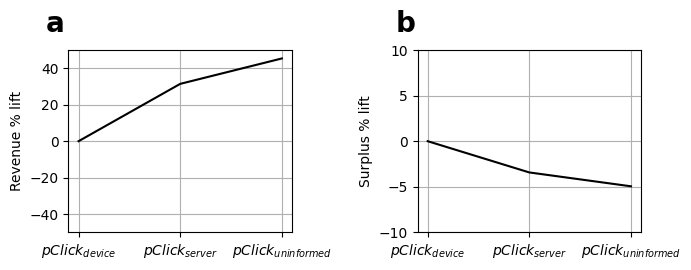

In [14]:
plot_aggregates(
    aggregates, 
    groups = {
        "":[
            'eBPMrank_personalized',
            'eBPM_1_pers_eBPM_g_rank_server',
            'eBPM_1_pers_eBPM_g_rank_global',
            ]
    },
    xticks=[r'$pClick_{device}$', r'$pClick_{server}$', r'$pClick_{uninformed}$'],
    metrics = ["eRPM","surplus"],
    rename_metrics = ["Revenue","Surplus"],
    savepath="../figures/pricing.png",
    figsize=(7,3),
    ylims={'CTR': (-50,50),'surplus': (-10,10), 'eRPM': (-50, 50)},
    
)

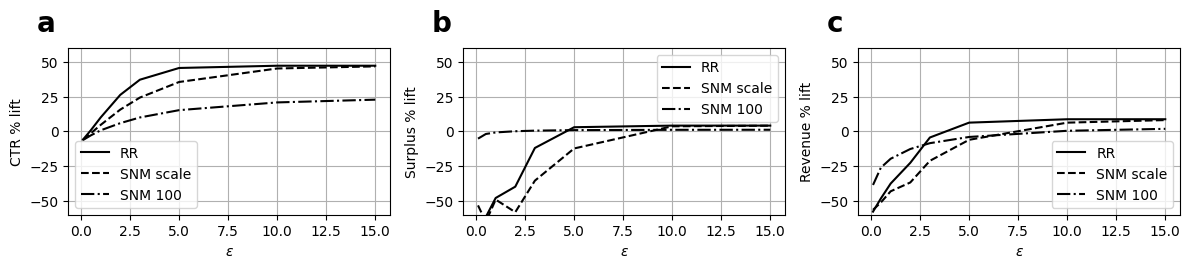

In [15]:
selector_groups = {
     "RR":[
         'eBPM_1_pers_eBPM_0o1_rr_rank_server',
         'eBPM_1_pers_eBPM_0o5_rr_rank_server',
         'eBPM_1_pers_eBPM_1_rr_rank_server',
         'eBPM_1_pers_eBPM_2_rr_rank_server',
         'eBPM_1_pers_eBPM_3_rr_rank_server',
         'eBPM_1_pers_eBPM_5_rr_rank_server',  
         'eBPM_1_pers_eBPM_10_rr_rank_server',  
         'eBPM_1_pers_eBPM_15_rr_rank_server',  
     ],
    r"SNM scale":[
        'eBPM_1_pers_eBPM_0o1_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_scale_eBPM_rank_server',
       ],
    r"SNM 100":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_100_rank_server',
       ],



}
plot_aggregates(
    aggregates, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(12,3),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "surplus", "eRPM"],
    rename_metrics =["CTR", "Surplus", "Revenue"],
    ylims={'CTR': (-60,60),'surplus': (-60,60), 'eRPM': (-60, 60)},
    xlabel = r"$\epsilon$",
    savepath="../figures/RNM_vs_RR.png",
)


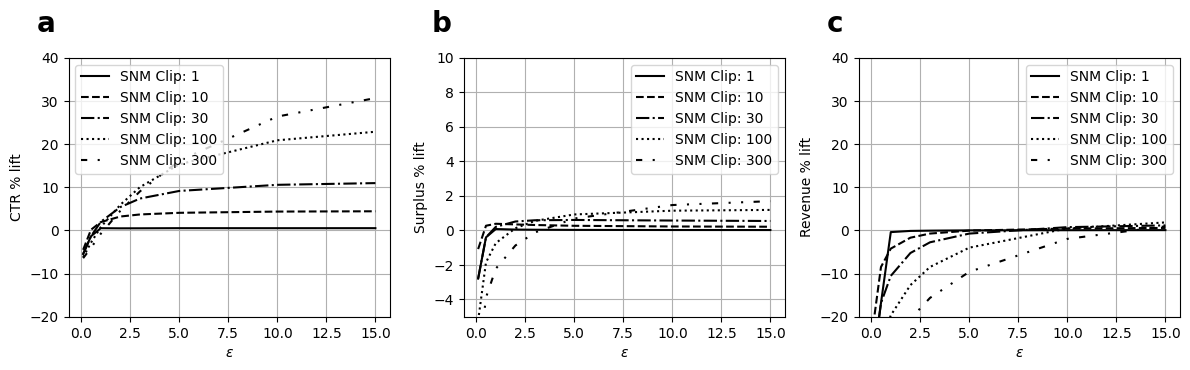

In [16]:
selector_groups = {
    r"SNM Clip: 1":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_1_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_1_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_1_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_1_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_1_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_1_rank_server',
       ],

    r"SNM Clip: 10":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_10_rank_server',
       ],
    r"SNM Clip: 30":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_30_rank_server',
       ],

    r"SNM Clip: 100":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_100_rank_server',
       ],
    r"SNM Clip: 300":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_300_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_300_rank_server',
       ],
}
plot_aggregates(
    aggregates, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(12,4),
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "surplus", "eRPM"],
    rename_metrics =["CTR", "Surplus", "Revenue"],
    ylims={'CTR': (-20,40),'surplus': (-5,10), 'eRPM': (-20, 40)},
    xlabel = r"$\epsilon$",
    savepath="../figures/SNM_clipbound.png",
)

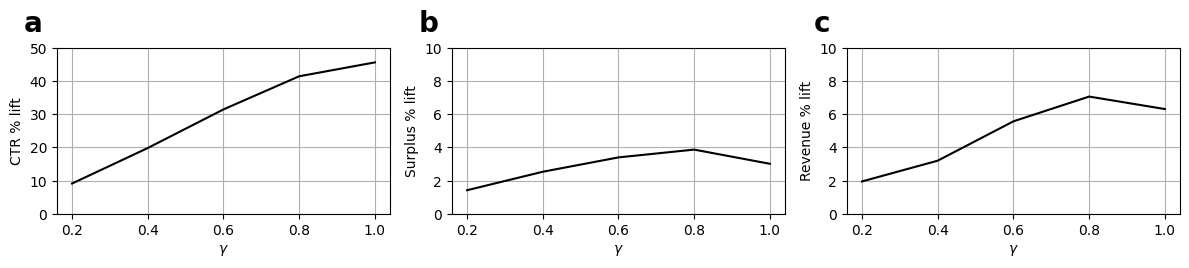

In [19]:
selector_groups = {
    "":[
        'eBPM_1_pers_eBPM_5_rr_rank_server',
        'eBPM_0o8_pers_eBPM_5_rr_rank_server',
        'eBPM_0o6_pers_eBPM_5_rr_rank_server',
        'eBPM_0o4_pers_eBPM_5_rr_rank_server',
        'eBPM_0o2_pers_eBPM_5_rr_rank_server',

        ],
                  }
plot_aggregates(
        aggregates, 
        groups = selector_groups,
        baseline='eBPMrank_server', 
        figsize=(12,3),
        xticks=[1,0.8,0.6,0.4, 0.2],
        metrics =["CTR",  "surplus", "eRPM"],
        rename_metrics =["CTR",  "Surplus", "Revenue"],
        savepath="../figures/rr-cutoff.png",
        ylims={'CTR': (0,50),'surplus': (0,10), 'eRPM': (0, 10)},
        xlabel = r"$\gamma$",
)


# Support for Appendix

## Alpha = 0.5

In [29]:
from dprecs.taobao import configs_alpha0o5
print(configs_alpha0o5.ALPHA, configs_alpha0o5.RESULTS_TABLE_NAME)

0.5 allegra_latimer.taobao_results_a0o5


In [30]:
configs_alpha0o5.RESULTS_TABLE_NAME = "allegra_latimer.taobao_results2_a0o5"

In [ ]:
(
        get_candidates(configs_alpha0o5, spark)
        .groupby(configs_alpha0o5.AUCTION_ID)
        .apply(
            pandas_udf(configs_alpha0o5.FINAL_SCHEMA, PandasUDFType.GROUPED_MAP)(
                lambda x: run_auction_group(x, configs_alpha0o5, run_paper_auction)
            )
        )
    .write
    .bucketBy(200, configs_alpha0o5.AUCTION_ID)
    .saveAsTable(configs_alpha0o5.RESULTS_TABLE_NAME, mode="overwrite", format="parquet")
)

In [ ]:
spark.sql(
    f"SELECT COUNT(DISTINCT({configs_alpha0o5.AUCTION_ID})) FROM {configs_alpha0o5.RESULTS_TABLE_NAME}"
).collect()

In [ ]:
auction_data_a0o5 = spark.sql(f"SELECT * FROM {configs_alpha0o5.RESULTS_TABLE_NAME}")

In [ ]:
selectors = [c for c in auction_data_a0o5.columns if ('rank' in c)]
aggregates_a0o5 = get_aggregates_pyspark(selectors, auction_data_a0o5)
aggregates_geq10_a0o5 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o5.filter(f"{configs.NUM_FINALISTS} >= 10"),
    estimators = ['dm','dr'])
aggregates_leq3_a0o5 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o5.filter(f"{configs.NUM_FINALISTS} <= 3"),
    estimators = ['dm','dr'])
aggregates_3t10_a0o5 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o5
    .filter(f"{configs.NUM_FINALISTS} > 3")
    .filter(f"{configs.NUM_FINALISTS} < 10"),
    estimators = ['dm','dr']
)

## alpha = 0.25

In [49]:
from dprecs.taobao import configs_alpha0o25
print(configs_alpha0o25.ALPHA, configs_alpha0o25.RESULTS_TABLE_NAME)

0.25 allegra_latimer.taobao_results2_a0o25


In [50]:
configs_alpha0o25.RESULTS_TABLE_NAME = "allegra_latimer.taobao_results2_a0o25"

In [ ]:
(
        get_candidates(configs_alpha0o25, spark)
        .groupby(configs_alpha0o25.AUCTION_ID)
        .apply(
            pandas_udf(configs_alpha0o25.FINAL_SCHEMA, PandasUDFType.GROUPED_MAP)(
                lambda x: run_auction_group(x, configs_alpha0o25, run_paper_auction)
            )
        )
    .write
    .bucketBy(200, configs_alpha0o25.AUCTION_ID)
    .saveAsTable(configs_alpha0o25.RESULTS_TABLE_NAME, mode="overwrite", format="parquet")
)

In [51]:
spark.sql(
    f"SELECT COUNT(DISTINCT({configs_alpha0o25.AUCTION_ID})) FROM {configs_alpha0o25.RESULTS_TABLE_NAME}"
).collect()

[Row(count(DISTINCT synth_auction_id)=6200969)]

In [52]:
auction_data_a0o25 = spark.sql(f"SELECT * FROM {configs_alpha0o25.RESULTS_TABLE_NAME}")

In [ ]:
selectors = [c for c in auction_data.columns if ('rank' in c)]
aggregates_a0o25 = get_aggregates_pyspark(selectors, auction_data_a0o5)
aggregates_geq10_a0o25 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o25.filter(f"{configs.NUM_FINALISTS} >= 10"),
    estimators = ['dm','dr'])
aggregates_leq3_a0o25 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o25.filter(f"{configs.NUM_FINALISTS} <= 3"),
    estimators = ['dm','dr'])
aggregates_3t10_a0o25 = get_aggregates_pyspark(
    selectors, 
    auction_data_a0o25
    .filter(f"{configs.NUM_FINALISTS} > 3")
    .filter(f"{configs.NUM_FINALISTS} < 10"),
    estimators = ['dm','dr']
)

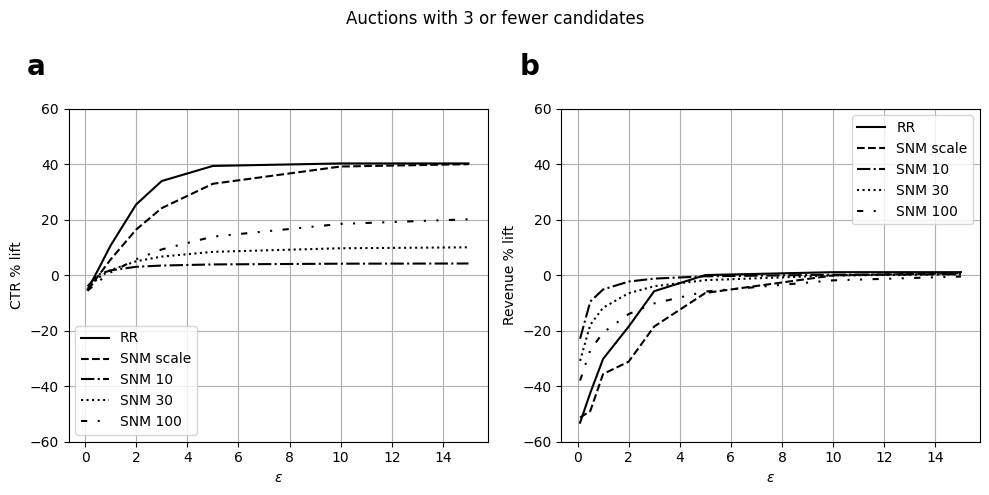

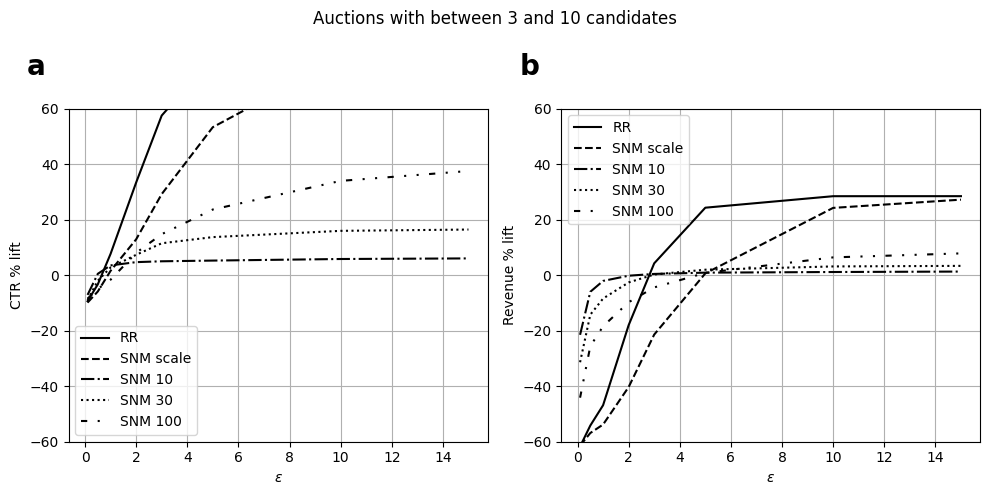

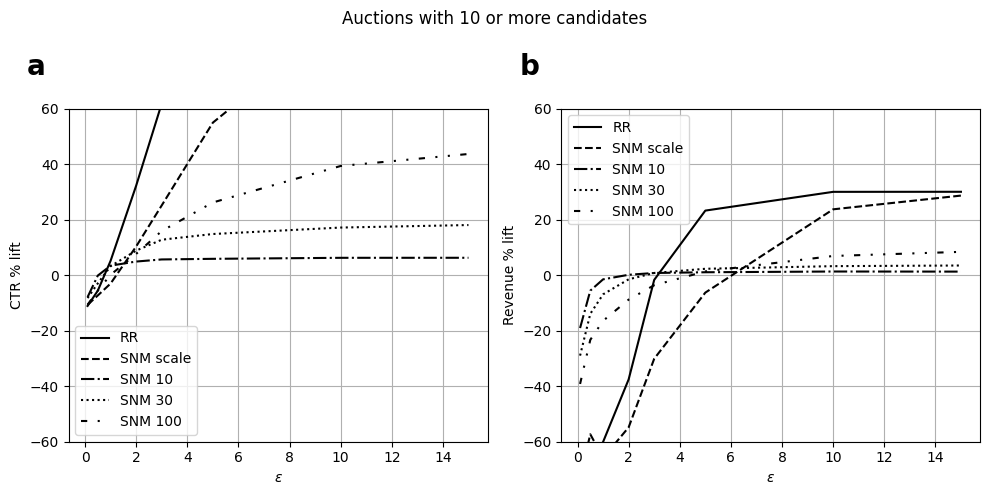

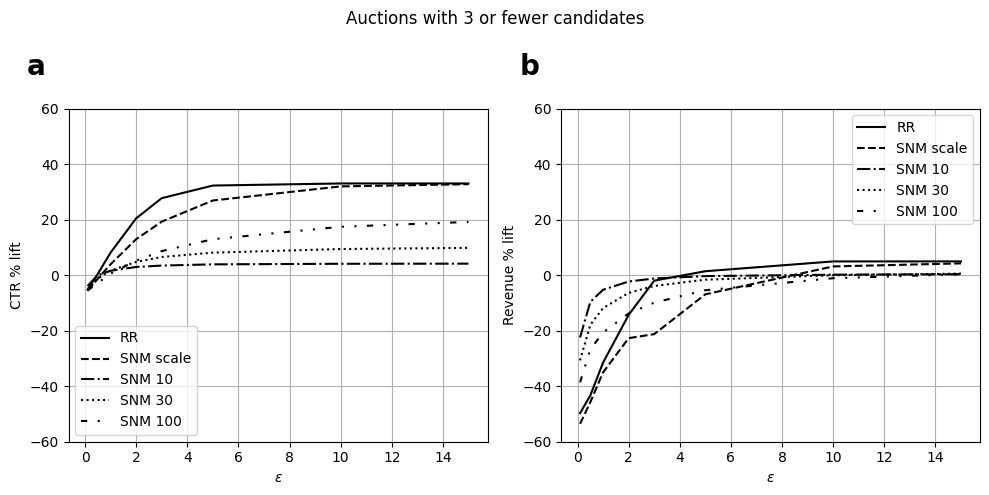

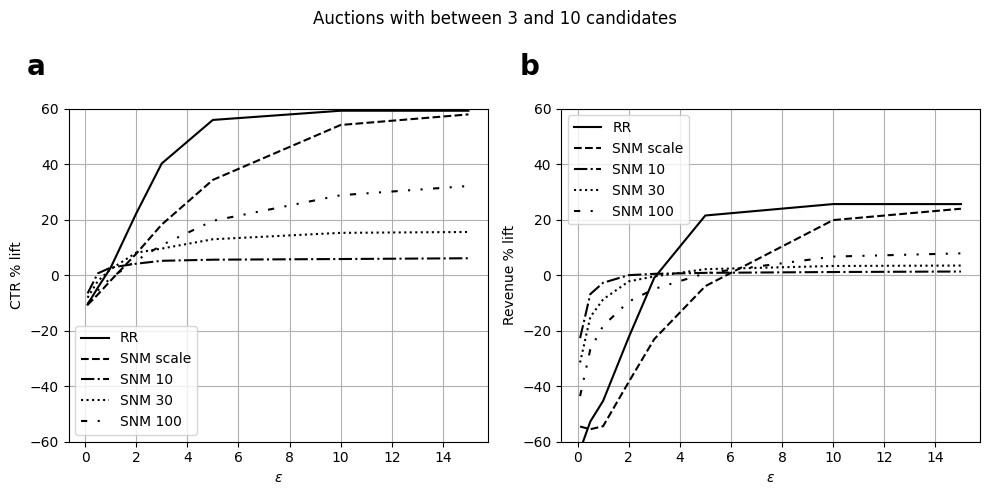

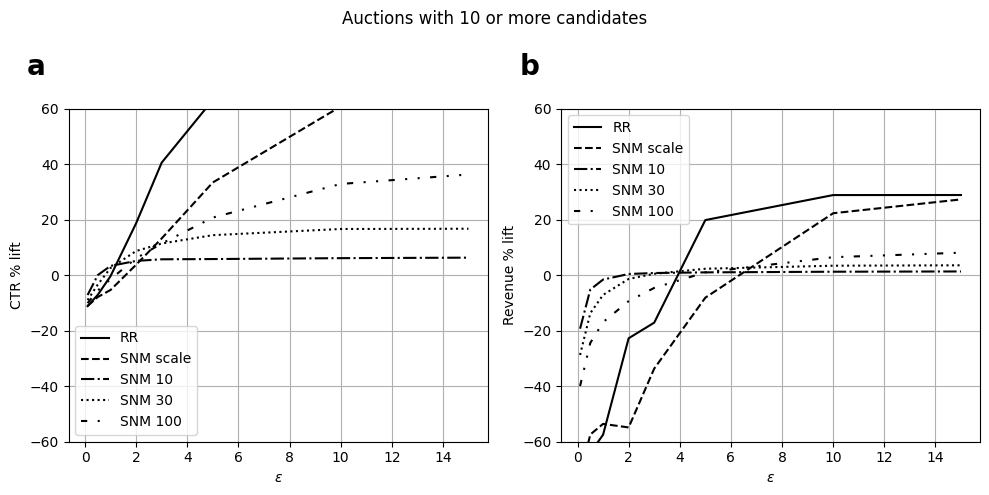

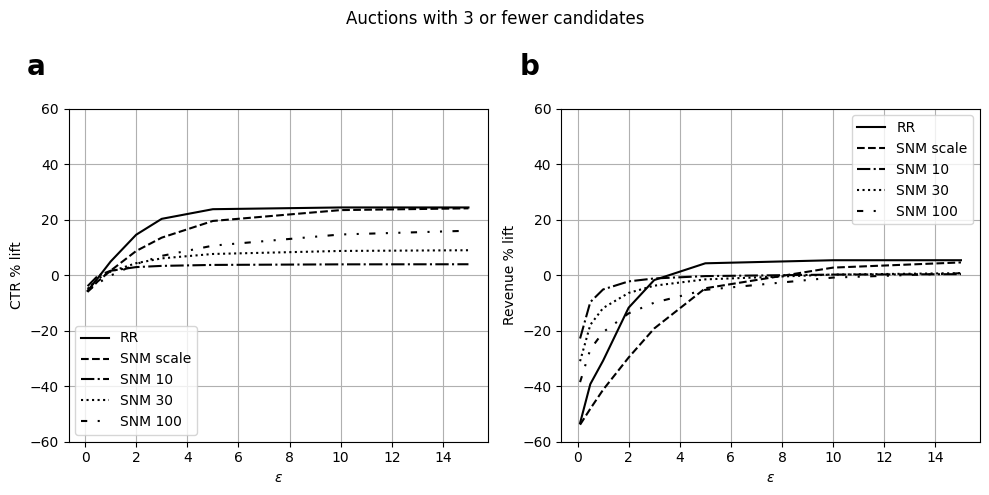

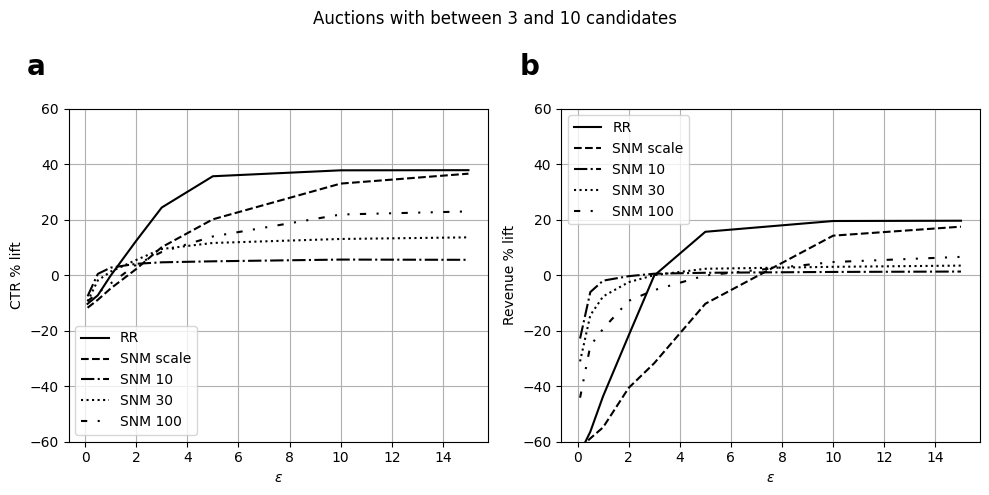

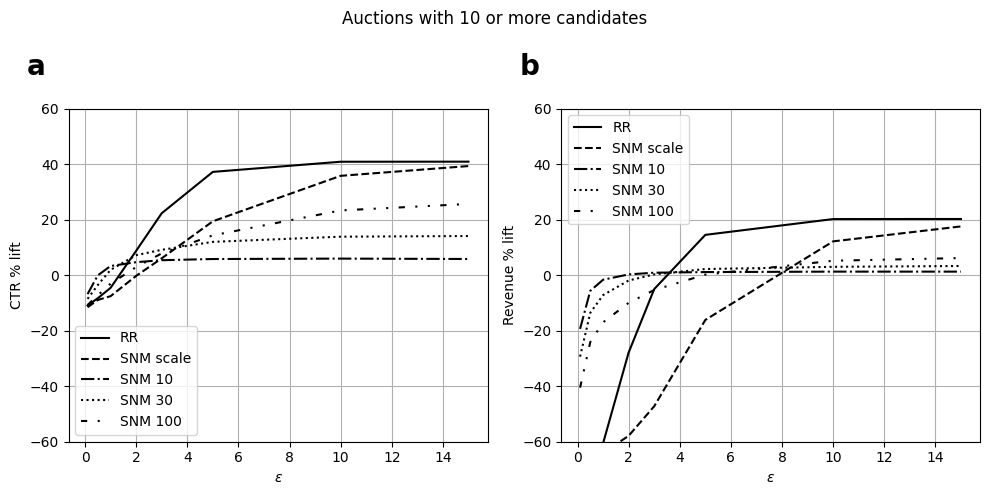

In [58]:
selector_groups = {
     "RR":[
         'eBPM_1_pers_eBPM_0o1_rr_rank_server',
         'eBPM_1_pers_eBPM_0o5_rr_rank_server',
         'eBPM_1_pers_eBPM_1_rr_rank_server',
         'eBPM_1_pers_eBPM_2_rr_rank_server',
         'eBPM_1_pers_eBPM_3_rr_rank_server',
         'eBPM_1_pers_eBPM_5_rr_rank_server',  
         'eBPM_1_pers_eBPM_10_rr_rank_server',  
         'eBPM_1_pers_eBPM_15_rr_rank_server',  
     ],
    r"SNM scale":[
        'eBPM_1_pers_eBPM_0o1_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_scale_eBPM_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_scale_eBPM_rank_server',
       ],
    r"SNM 10":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_10_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_10_rank_server',
       ],
    r"SNM 30":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_30_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_30_rank_server',
       ],
    r"SNM 100":[
        'eBPM_1_pers_eBPM_0o1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_0o5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_1_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_2_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_3_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_5_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_10_rnme_smart_clip_eBPM_100_rank_server',
        'eBPM_1_pers_eBPM_15_rnme_smart_clip_eBPM_100_rank_server',
       ],
}

# Alpha 1
plot_aggregates(
    aggregates_leq3, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 3 or fewer candidates",
)
plot_aggregates(
    aggregates_3t10, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with between 3 and 10 candidates",
)
plot_aggregates(
    aggregates_geq10, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 10 or more candidates",
)

# Alpha 0.5
plot_aggregates(
    aggregates_leq3_a0o5, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 3 or fewer candidates",
)
plot_aggregates(
    aggregates_3t10_a0o5, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with between 3 and 10 candidates",
)
plot_aggregates(
    aggregates_geq10_a0o5, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 10 or more candidates",
)

# Alpha 0.25
plot_aggregates(
    aggregates_leq3_a0o25, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 3 or fewer candidates",
)
plot_aggregates(
    aggregates_3t10_a0o25, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with between 3 and 10 candidates",
)
plot_aggregates(
    aggregates_geq10_a0o25, 
    groups = selector_groups,
    baseline='eBPMrank_server', 
    figsize=(10,5),
    estimator="dr",
    xticks=[0.1, 0.5, 1, 2, 3, 5, 10, 15],
    metrics =["CTR", "eRPM"],
    rename_metrics =["CTR", "Revenue"],
    ylims={'CTR': (-60,60), 'eRPM':(-60,60)},
    xlabel = r"$\epsilon$",
    title="Auctions with 10 or more candidates",
)



## Analyses on small data sample

In [60]:
auction_data_small = spark.sql(f"""
SELECT *
FROM {configs.RESULTS_TABLE_NAME}
INNER JOIN (
        SELECT
            {configs.AUCTION_ID} AS secondary_auction_id
        FROM {configs.RESULTS_TABLE_NAME}
        GROUP BY {configs.AUCTION_ID} 
        ORDER BY RAND(42)
        LIMIT 10000
    ) auction_ids
    ON {configs.AUCTION_ID}=secondary_auction_id
""").toPandas()

auction_data_small_a0o5 = spark.sql(f"""
SELECT *
FROM {configs_alpha0o5.RESULTS_TABLE_NAME}
INNER JOIN (
        SELECT
            {configs.AUCTION_ID} AS secondary_auction_id
        FROM {configs.RESULTS_TABLE_NAME}
        GROUP BY {configs.AUCTION_ID} 
        ORDER BY RAND(42)
        LIMIT 10000
    ) auction_ids
    ON {configs.AUCTION_ID}=secondary_auction_id
""").toPandas()

auction_data_small_a0o25 = spark.sql(f"""
SELECT *
FROM {configs_alpha0o25.RESULTS_TABLE_NAME}
INNER JOIN (
        SELECT
            {configs.AUCTION_ID} AS secondary_auction_id
        FROM {configs.RESULTS_TABLE_NAME}
        GROUP BY {configs.AUCTION_ID} 
        ORDER BY RAND(42)
        LIMIT 10000
    ) auction_ids
    ON {configs.AUCTION_ID}=secondary_auction_id
""").toPandas()

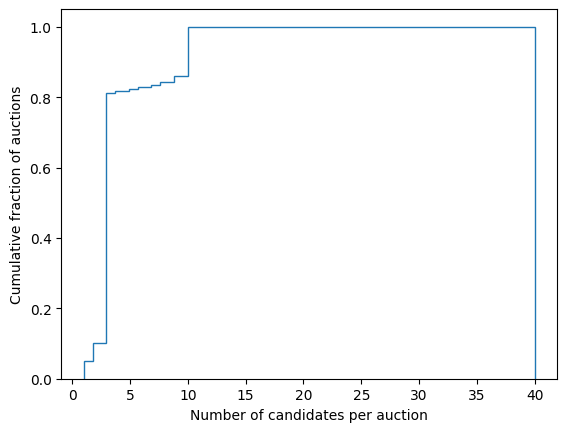

In [118]:
plt.hist(
    auction_data_small
    .groupby(configs.AUCTION_ID)
    [configs.AUCTION_ID]
    .count(),
    cumulative=True,
    density=1,
    histtype = "step",
    bins=100
)
plt.ylabel("Cumulative fraction of auctions")
plt.xlabel("Number of candidates per auction")
plt.savefig("../figures/no-candidates-cdf.png")
plt.show()

### Delta pCTRS

In [62]:
a1_delta_pttrs = (
    abs(auction_data_small[configs.SERVER_PCTR] - auction_data_small[configs.PERSONALIZED_PCTR])
).values

a0o5_delta_pttrs = (
    abs(auction_data_small_a0o5[configs.SERVER_PCTR] - auction_data_small_a0o5[configs.PERSONALIZED_PCTR])
).values

a0o25_delta_pttrs = (
    abs(auction_data_small_a0o25[configs.SERVER_PCTR] - auction_data_small_a0o25[configs.PERSONALIZED_PCTR])
).values

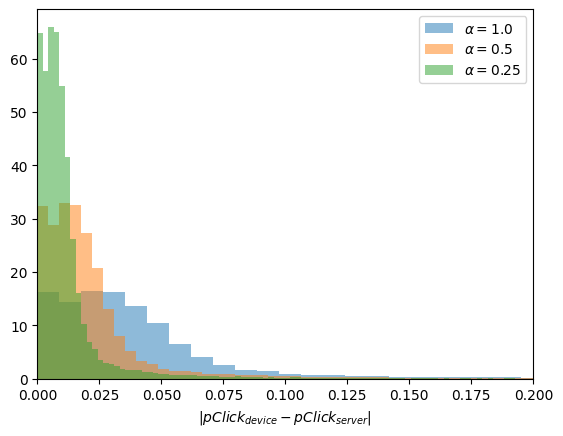

In [70]:
plt.hist( a1_delta_pttrs, density=1, bins=100, label=r"$\alpha=1.0$", alpha=0.5)
plt.hist( a0o5_delta_pttrs, density=1, bins=100, label=r"$\alpha=0.5$", alpha=0.5)
plt.hist( a0o25_delta_pttrs, density=1, bins=100, label=r"$\alpha=0.25$", alpha=0.5)
plt.xlabel(r"$|pClick_{device}-pClick_{server}|$")
plt
plt.legend()
plt.xlim(0,0.2)
plt.savefig("../figures/delta_pclick.png",dpi=300)
plt.show()


## SNM vs RR deep dive

In [108]:
from dprecs.random_selectors import get_rr_probas, get_expmech_probas, clip_scores, scale_scores
from collections import OrderedDict

def get_mean_scores_vs_epsilon(
    all_pvt_scores, 
    all_pub_scores, 
    epsrange = np.linspace(0.01, 10, 20), 
    clip_bound=5
):

    num_auctions = len(all_pvt_scores)
    
    rr = np.zeros((epsrange.shape[0], num_auctions))
    scale_snm = np.zeros((epsrange.shape[0], num_auctions))
    truncate_snm = np.zeros((epsrange.shape[0], num_auctions))
    truncate_smart_snm = np.zeros((epsrange.shape[0], num_auctions))
    pub_greedy = np.zeros((epsrange.shape[0], num_auctions))
    pvt_greedy = np.zeros((epsrange.shape[0], num_auctions))
    smart_choose = np.zeros((epsrange.shape[0], num_auctions))
    
    for e, eps in enumerate(epsrange):
        for a in range(num_auctions):
            pvt_scores = all_pvt_scores[a]
            pub_scores = all_pub_scores[a]
            pub_greedy[e, a] = pvt_scores[pub_scores.argmax()]
            pvt_greedy[e, a] = pvt_scores.max()
            rr[e, a] = (get_rr_probas(pvt_scores, eps) * pvt_scores).sum()
            scale_snm[e, a] = (
                get_expmech_probas(
                    scale_scores(pvt_scores), sensitivity=1, eps=eps
                ) * pvt_scores
            ).sum()
            truncate_smart_snm[e, a] = (
                get_expmech_probas(
                    clip_scores(pvt_scores, pub_scores, clip_bound), 
                    sensitivity = 2*clip_bound, 
                    eps = eps,
                ) * pvt_scores
            ).sum()
            truncate_snm[e, a] = (
                get_expmech_probas(
                    clip_scores(pvt_scores, pub_scores.mean(), clip_bound), 
                    sensitivity = 2*clip_bound, 
                    eps = eps,
                ) * pvt_scores
            ).sum()

            if rr[e, a] >= truncate_smart_snm[e, a]:
                smart_choose[e, a] = rr[e, a]
            else:
                smart_choose[e, a] = truncate_smart_snm[e, a]


    return OrderedDict({
        "Greedy: non-private":pvt_greedy,
        "Greedy: non-personalized":pub_greedy, 
        "RR":rr, 
        "SNM: scaled":scale_snm, 
        "SNM: clipped":truncate_smart_snm, 
    })
    
def plot_scores(scores, 
                ylim = None,
                epsrange = np.linspace(0.01, 10, 20),
                title=None,
                figsize=(6,6),
                ):
    fig, axs = plt.subplots(scores['Greedy: non-private'].shape[1], 1, figsize=figsize)
    colors = ["k", "b", "r", "g", "c", "m", "orange", "yellow"]
    linestyles = ["-","--","-.",":",(0, (3, 5, 1, 5, 1, 5)), (0, (1, 10)), (5, (10, 3)), (0, (5, 10))]
    for a, ax in enumerate(axs.flatten()):
        i=0
        for label, auctions_score in scores.items():
            i+=1
            score = auctions_score[:,a]
            ax.plot( epsrange, score, ls=linestyles[i], label=label, color='k')

        ax.set_xlabel(r"$\epsilon$")
        ax.set_ylabel(r"Mean Score")
        if ylim:
            ax.set_ylim(ylim)
        if title:
            ax.set_title(title)
    plt.legend(loc='lower right')
    plt.show()
    
def plot_scores_std(scores, 
                ylim = None,
                epsrange = np.linspace(0.01, 10, 20),
                title=None,
                ):
    colors = ["k", "b", "r", "g", "c", "m", "orange", "yellow"]
    linestyles = ["-","--","-.",":",(0, (3, 5, 1, 5, 1, 5)), (0, (1, 10)), (5, (10, 3)), (0, (5, 10))]
    i=0
    for label, score in scores.items():
        i+=1
        plt.plot( epsrange, score.mean(axis=1), ls=linestyles[i], label=label, color='k')
        plt.fill_between(
                epsrange, 
                score.mean(axis=1) - score.std(axis=1), 
                score.mean(axis=1) + score.std(axis=1), 
                color='k', 
                alpha=0.2
            )
        plt.xlabel(r"$\epsilon$")
        plt.ylabel(r"Mean Score")
        if ylim:
            plt.ylim(ylim)
        if title:
            plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

## Sampling auctions with 3 candidates

['5853461494343160' '6468681494084433' '5984951494522198']
[array([ 47.77947998, 416.28134155, 145.83036804])
 array([121.62637329,  63.10968781,  42.70638275])
 array([ 12.00437355,  95.60402679, 108.58937836])] [array([ 85.84030151, 359.98562622, 100.88601685])
 array([ 26.18976021,  53.99340057, 102.54830933])
 array([199.20326233, 413.74328613, 221.58982849])]


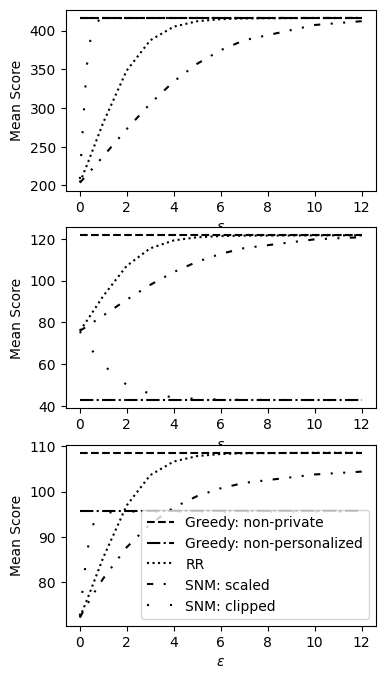

In [101]:
epsrange = np.array((0.01, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7, 10, 12))

# Consider random seeds 40-50
np.random.seed(44)
auction_ids = np.random.choice(auction_data_small
                               .loc[lambda df: df[configs.NUM_FINALISTS]==3][configs.AUCTION_ID]
                               .unique(), 3)

all_pvt_scores = (
    auction_data_small
    .loc[lambda x: x[configs.AUCTION_ID].isin(auction_ids)]
    [[configs.AUCTION_ID, 'eBPM_personalized']]
    .groupby(configs.AUCTION_ID)
    .apply(lambda df: df['eBPM_personalized'].values)
).values

all_pub_scores = (
    auction_data_small
    .loc[lambda x: x[configs.AUCTION_ID].isin(auction_ids)]
    [[configs.AUCTION_ID, 'eBPM_server']]
    .groupby(configs.AUCTION_ID)
    .apply(lambda df: df['eBPM_server'].values)
).values

print(auction_ids)
print(all_pvt_scores, all_pub_scores)

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pub_scores, 
    epsrange = epsrange, 
    clip_bound = 10, #empirical
)

plot_scores(
    scores, 
    epsrange =  epsrange, 
    title="",
    figsize=(4,8)
)  

['2491061494228746' '10301791494342676' '2442301494417819']
[array([ 405.15945435,  105.09925079,   55.62292099,  120.10244751,
         56.24098969,   24.86724663,   49.50146484,  185.67184448,
         42.52022934, 5871.78613281])
 array([ 44.04624939,  18.36911201,  23.51335907,   9.51324558,
       106.8247757 ,  58.94238663,  22.40986633,  75.78284454,
       169.76501465,   7.82355738])
 array([ 6.71802616,  6.08659649,  2.43354869, 12.22879887, 14.83050346,
        6.18305969, 14.15242863,  2.14908719, 12.56751633,  1.56717861])] [array([ 130.56890869,  169.19566345,   18.54677582,  431.12088013,
         41.95295334,   47.21617889,   41.72454453,   96.42986298,
         26.52266121, 1845.4675293 ])
 array([ 66.56732178,  38.9527092 ,  23.62721825,  29.41845703,
        90.93411255,  39.58701706,  48.58380508, 125.16798401,
       154.91235352,  60.84222031])
 array([ 42.48704529,  44.70746231,  19.11247826,   4.52562761,
        55.98779297,   2.32720637, 130.54948425,  35.9452

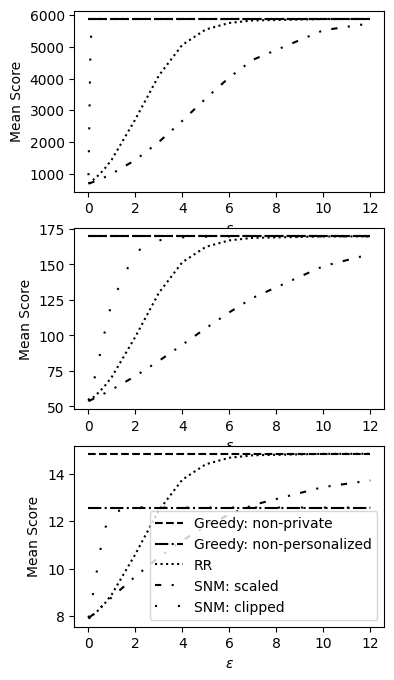

In [100]:
epsrange = np.array((0.01, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7, 10, 12))

# Consider random seeds 40-50
np.random.seed(44)
auction_ids = np.random.choice(auction_data_small
                               .loc[lambda df: df[configs.NUM_FINALISTS]==10][configs.AUCTION_ID]
                               .unique(), 3 )

all_pvt_scores = (
    auction_data_small
    .loc[lambda x: x[configs.AUCTION_ID].isin(auction_ids)]
    [[configs.AUCTION_ID, 'eBPM_personalized']]
    .groupby(configs.AUCTION_ID)
    .apply(lambda df: df['eBPM_personalized'].values)
).values

all_pub_scores = (
    auction_data_small
    .loc[lambda x: x[configs.AUCTION_ID].isin(auction_ids)]
    [[configs.AUCTION_ID, 'eBPM_server']]
    .groupby(configs.AUCTION_ID)
    .apply(lambda df: df['eBPM_server'].values)
).values

print(auction_ids)
print(all_pvt_scores, all_pub_scores)

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pub_scores, 
    epsrange = epsrange, 
    clip_bound = 10, #empirical
)

plot_scores(
    scores, 
    epsrange =  epsrange, 
    title="",
    figsize=(4,8)
)  

### Synthetic data 
- uniformative public scores, so only compare scaling snm vs rr
- no. arms and distribution type

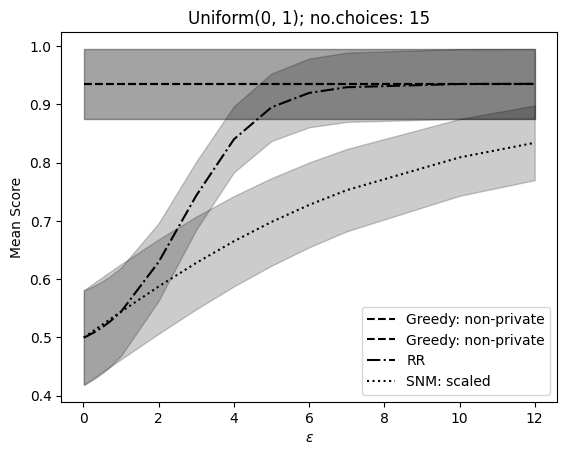

In [109]:
all_pvt_scores = []
num_choices = 15
np.random.seed(42)
for i in range(100):
    all_pvt_scores.append(
        np.random.uniform(low=0, high=1, size=num_choices)
    )

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pvt_scores, 
    epsrange = epsrange, 
    clip_bound = 1,
)
keys_to_plot = ["Greedy: non-private", "RR", "SNM: scaled"]
plot_scores_std(
    {k:v for k,v in scores.items() if k in keys_to_plot}, 
    epsrange =  epsrange,
    title=f"Uniform(0, 1); no.choices: {num_choices}",
)    

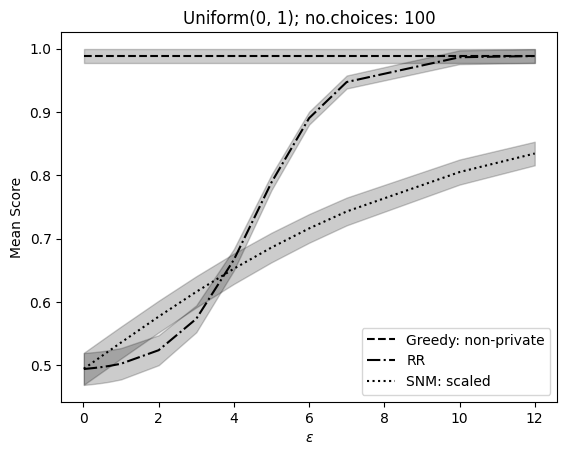

In [111]:
all_pvt_scores = []
num_choices = 100
np.random.seed(42)
for i in range(100):
    all_pvt_scores.append(
        np.random.uniform(low=0, high=1, size=num_choices)
    )

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pvt_scores, 
    epsrange = epsrange, 
    clip_bound = 1,
)
keys_to_plot = ["Greedy: non-private", "RR", "SNM: scaled"]
plot_scores_std(
    {k:v for k,v in scores.items() if k in keys_to_plot}, 
    epsrange =  epsrange,
    title=f"Uniform(0, 1); no.choices: {num_choices}",
)    

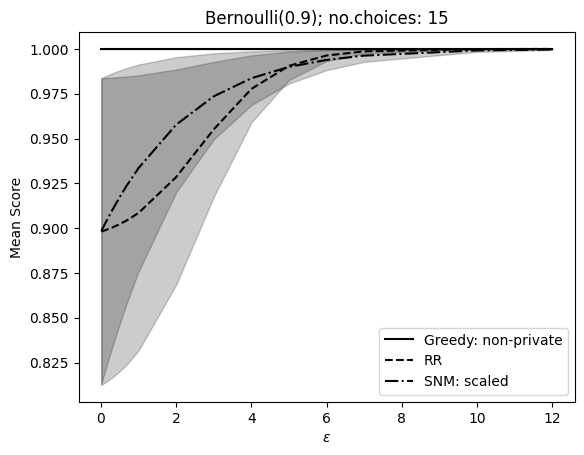

In [119]:
all_pvt_scores = []
num_choices = 15
np.random.seed(42)
for i in range(100):
    all_pvt_scores.append(
        np.random.binomial(n=1,p=0.9, size=num_choices)
    )

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pvt_scores, 
    epsrange = epsrange, 
    clip_bound = 1,
)
keys_to_plot = ["Greedy: non-private", "RR", "SNM: scaled" ]
plot_scores(
    {k:v for k,v in scores.items() if k in keys_to_plot}, 
    epsrange =  epsrange,
    title=f"Bernoulli(0.9); no.choices: {num_choices}",
)    

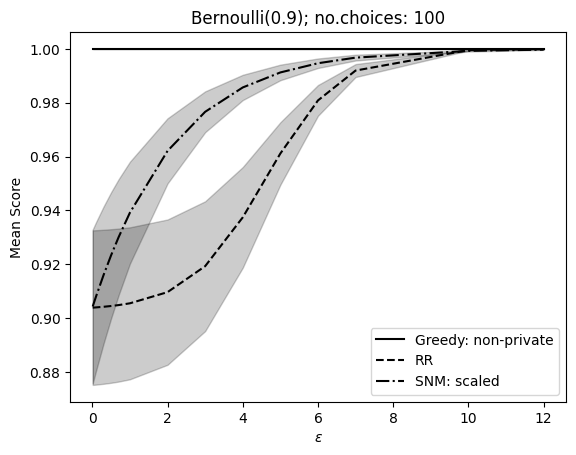

In [120]:
all_pvt_scores = []
num_choices = 100
np.random.seed(42)
for i in range(100):
    all_pvt_scores.append(
        np.random.binomial(n=1,p=0.9, size=num_choices)
    )

scores = get_mean_scores_vs_epsilon(
    all_pvt_scores,
    all_pvt_scores, 
    epsrange = epsrange, 
    clip_bound = 1,
)
keys_to_plot = ["Greedy: non-private", "RR", "SNM: scaled" ]
plot_scores(
    {k:v for k,v in scores.items() if k in keys_to_plot}, 
    epsrange =  epsrange,
    title=f"Bernoulli(0.9); no.choices: {num_choices}",
)    

###### 